In [34]:
import os
import glob
import uproot
import omegaconf
import matplotlib.pyplot as plt
from termcolor import colored
import yaml
import seaborn as sns
import numpy as np
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

%matplotlib inline

In [3]:
def check_condor_log(logfile):
    retcode = -999
    with open(logfile) as f:
        for line in f:
            if 'exit-code' in line:
                retcode = line[-2]
    
    return retcode

In [4]:
class Status:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

    @classmethod
    def success(self, text):
        print(f"{text}: {self.OKGREEN}Success{self.ENDC}")
    
    @classmethod
    def fail(self, text):
        print(f"{text}: {self.FAIL}Fail{self.ENDC}")

    @classmethod
    def running(self, text):
        print(f"{text}: {self.OKBLUE}Running{self.ENDC}")

    @classmethod
    def status(self, text, status):
        if status == 'Fail': self.fail(text)
        if status == 'Success': self.success(text)
        if status == 'Running': self.running(text)


In [5]:
def check_status(job_folder):

    status = 'Fail'

    condor_log = glob.glob(f"{job_folder}/generation*.log")
    stdout_log = glob.glob(f"{job_folder}/generation*.out")
    stderr_log = glob.glob(f"{job_folder}/generation*.out")
    output_rootfile = glob.glob(f"{job_folder}/output*.root")

    # If we have an stdout then job has completed
    if stdout_log and not output_rootfile:
        status = 'Fail'
    elif stdout_log and output_rootfile:
        status = 'Success'
    else:
        status = 'Running'
    
    return job_folder, status

In [6]:
def status(sample_folder):

    job_folders = [p for p in glob.glob(f"{sample_folder}/*") if os.path.isdir(p)]

    status_of_jobs = [check_status(p) for p in job_folders]

    for (job_folder, status) in status_of_jobs:

        if status == "Fail":
            print(os.path.basename(job_folder), colored(status, 'red'))
        if status == 'Success':
            print(os.path.basename(job_folder), colored(status, 'green'))
        if status == 'Running':
            print(os.path.basename(job_folder), colored(status, 'blue'))

    # plt.table(cellText=status_of_jobs,
    #           rowLabels=["Jobs"],
    #         #   rowColours=colors,
    #           colLabels=['Status'])

    return sample_folder


In [7]:
# Create drop down menu to select the simulation run
runs = [p for p in glob.glob("multirun/*") if os.path.isdir(p)];
interact(status, sample_folder=runs);


interactive(children=(Dropdown(description='sample_folder', options=('multirun/2023-03-09_typeII_single_prod_W…

In [8]:
print(colored('red', 'red'))

red


In [9]:
def extract_parameters(job_folder):
    overrides_file = os.path.join(job_folder, '.hydra', 'overrides.yaml')

    overrides = {}
    with open(overrides_file, "r") as stream:
        overrides = yaml.safe_load(stream)
    # omegaconf.OmegaConf.load(overrides_file)

    print(overrides)
    return overrides

In [10]:
job_folders = [p for p in glob.glob("multirun/2023-03-09_typeII_single_prod_WWjj/*") if os.path.isdir(p)]

parameters = []

for f in job_folders:
    parameters.append(extract_parameters(f))


['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=0', 'parameters.MDPP=1300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-4', 'parameters.MDPP=1100', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-1', 'parameters.MDPP=300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=700', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-1', 'parameters.MDPP=1900', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=0', 'parameters.MDPP=300', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-1', 'parameters.MDPP=1500', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=1700', 'batch=True']
['+process=typeII_vbs_bosonic', 'parameters.log10_vevD=-6', 'parameters.MDPP=1300', 'batch=True']
['+process=typeII_vbs_boso

In [11]:
params = []
process = ""

for entry in parameters[0]:
    if 'process' in entry:
        process = entry.split('=')[-1]
    if 'parameters' in entry:
        params.append(entry.split("parameters.")[-1].split('=')[0])

print(process, params)

typeII_vbs_bosonic ['log10_vevD', 'MDPP']


In [42]:
results = {}
failed_results = {}

for folder in job_folders:
    vevd = float(str(float(os.path.basename(folder).split('_')[-1])))
    results[vevd] = {'mdpp': [], 'xsec': [], 'nevents_i': [], 'nevents_f': []}

results = OrderedDict(sorted(results.items()))

for folder in job_folders:
    vevd = str(float(os.path.basename(folder).split('_')[-1]))
    mdpp = float(os.path.basename(folder).split('_')[-2])
    xsec = 0
    file_exists = True
    try:
        metadata = uproot.open(f"{folder}/output.root:metadata")
    except Exception:
        file_exists = False
        pass

    if file_exists:
        xsec =      metadata['total_xs'].array(library='np')[0]
        nevents_i = metadata['ninit_events'].array(library='np')[0]
        nevents_f = metadata['nsurvive_events'].array(library='np')[0]

        results[str(vevd)]['mdpp'].append(mdpp)
        results[str(vevd)]['xsec'].append(xsec)
        results[str(vevd)]['nevents_i'].append(nevents_i)
        results[str(vevd)]['nevents_f'].append(nevents_i)
    else:
        results[str(vevd)]['mdpp'].append(mdpp)
        results[str(vevd)]['xsec'].append(None)
        results[str(vevd)]['nevents_i'].append(None)
        results[str(vevd)]['nevents_f'].append(None)

        
fig, ax = plt.subplots()

for vevd, value in results.items():
    list1 = value['mdpp']
    list2 = value['xsec']

    print(list1, list2)

    list1, list2 = zip(*sorted(zip(list1, list2)))

    ax.plot(list1, list2, label=vevd)

ax.legend(title='vevD');
ax.set_yscale('log');
ax.set_xlabel(r"$M_{\Delta^{++}}$ [GeV]");
ax.set_ylabel(r"$\sigma$ (fb)");




KeyError: '1.0'

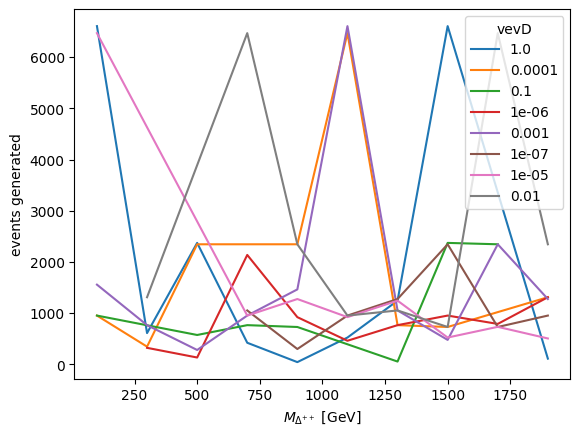

In [18]:
fig, ax = plt.subplots()

for vevd, value in results.items():
    list1 = value['mdpp']
    list2 = value['nevents_i']
    list1, list2 = zip(*sorted(zip(list1, list2)))

    ax.plot(list1, list2, label=vevd)

ax.legend(title='vevD');
ax.set_xlabel(r"$M_{\Delta^{++}}$ [GeV]");
ax.set_ylabel("events generated");

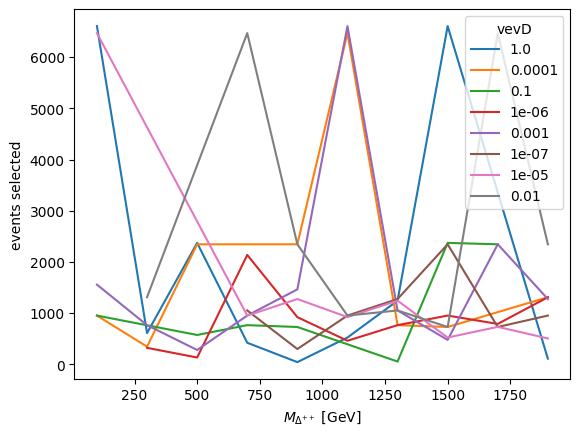

In [19]:
fig, ax = plt.subplots()

for vevd, value in results.items():
    list1 = value['mdpp']
    list2 = value['nevents_f']
    list1, list2 = zip(*sorted(zip(list1, list2)))

    ax.plot(list1, list2, label=vevd)

ax.legend(title='vevD');
ax.set_xlabel(r"$M_{\Delta^{++}}$ [GeV]");
ax.set_ylabel("events selected");

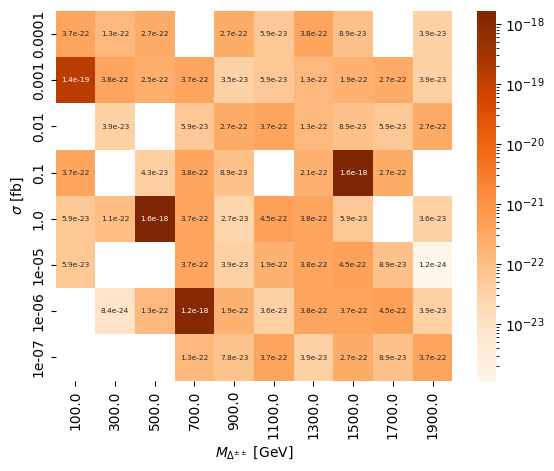

In [41]:
from matplotlib.colors import LogNorm, Normalize

hmap = []
mdpps = []
vevds = results.keys()

for vevd, value in results.items():
    list1 = value['mdpp']
    list2 = value['xsec']
    list1, list2 = zip(*sorted(zip(list1, list2)))

    mdpps = list1
    hmap.append(list2)

hmap = np.array(hmap, dtype=float)

fig, ax = plt.subplots()
sns.heatmap(hmap, annot=True, cmap="Oranges", xticklabels=mdpps, yticklabels=vevds, ax=ax,
						fmt=".2", vmin=0, vmax=1, norm=LogNorm(), annot_kws={"size": 15 / np.sqrt(len(hmap))});
ax.set_xlabel(r"$M_{\Delta^{\pm\pm}}$ [GeV]");
ax.set_ylabel(r"$\sigma$ [fb]");

In [62]:
from dataclasses import dataclass

@dataclass
class Result:
    vevd: float
    mdpp: float
    quantity: float
    file: str

    def __lt__(self, other):
        return self.vevd < other.vevd

def get_results(samples_dir, quantity):
    
    override_cgfs_paths = glob.glob(f"{samples_dir}/*/.hydra/overrides.yaml")
    
    results = []

    for fpath in override_cgfs_paths:
        with open(fpath) as f:
            cfg_list = yaml.safe_load(f)
            vevd = -999
            mdpp = -999
            for item in cfg_list:
                if 'vevD' in item:
                    vevd = 10**float(item.split("=")[-1])
                if 'MDPP' in item:
                    mdpp = float(item.split("=")[-1])

            root_file = f"{os.path.dirname(os.path.dirname(fpath))}/output.root"

            try:
                data = uproot.open(f"{root_file}:metadata")
                value = data[quantity].array(library='np')[0]
            except Exception:
                value=None

            results.append(Result(vevd, mdpp, value, root_file))
        
    results.sort();
    return results

    

In [67]:
import operator

def plot_results(results, name, log):

    vevds = set([r.vevd for r in results])
    mdpps = set([r.mdpp for r in results])

    hmap = []

    for v in vevds:
        results_msorted = sorted(results, key=operator.attrgetter('mdpp'))
        hmap.append([r.quantity for r in results_msorted if r.vevd == v])
        
    hmap = np.array(hmap, dtype=float)

    fig, ax = plt.subplots()
    if log:
        sns.heatmap(hmap, annot=True, cmap="Oranges", xticklabels=mdpps, yticklabels=vevds, ax=ax,
                    fmt=".2", norm=LogNorm(), annot_kws={"size": 15 / np.sqrt(len(hmap))},
                    cbar_kws={'label': name});
    if not log:
        sns.heatmap(hmap, annot=True, cmap="Oranges", xticklabels=mdpps, yticklabels=vevds, ax=ax,
                    fmt=".2", annot_kws={"size": 15 / np.sqrt(len(hmap))},
                    cbar_kws={'label': name});

    ax.set_xlabel(r"$M_{\Delta^{\pm\pm}}$ [GeV]");
    ax.set_ylabel(r"vevD [GeV]");

In [68]:
def select(sample_folder, variable, log):
    results = get_results(sample_folder, variable)
    plot_results(results, variable, log)

runs = glob.glob("multirun/*")
choices = ["total_xs", "total_xs_error", "sum_of_weights", "sum_of_weights_err", "fid_sum_of_weights", "fid_sum_of_weights_err", "fid_xs", "fid_xs_err", "nsurvive_events", "ninit_events",  "presel_eff",   "cutflow"]

interact(select, sample_folder=runs, variable=choices, log=[True, False]);

interactive(children=(Dropdown(description='sample_folder', options=('multirun/2023-03-13_typeII_single_prod_l…